In [1]:
import sys
sys.path.insert(0, '../tools')

%load_ext prov_magics
import intertwined_prov
from qintertwined_prov import *

In [2]:
def get_original_reference(ref, result=None):
    D, TX, TX2 = var(3)
    if result is None:
        result = set()
    first = False
    while not first:
        first = True
        query = [
            (D.bound, TX.bound, TX2.bound) 
            for __ in (
                was_derived_from(ref, D, type="Reference", text=TX)
                & entity(D, text=TX2)
            )]
        if query:
            ref, text, text2 = query[0]
            result.add(text)
            result.add(text2)
            first = False
    return ref, result

In [3]:
import datetime
from collections import namedtuple, deque
from copy import copy
from pprint import pprint

Context = namedtuple("Context", "type to_parts moment")

def neighborhood(context):
    n, move_to_parts, time = context
    
    temp_time = datetime.datetime.max
    
    _ = BLANK
    A, C, D, T, TP, U, W, TX, TX2, TX3 = var("A C D T TP U W TX TX2 TX3")
    
    # Follow default derivations
    query = (
        was_derived_from(n, D, _, _, _, type=TP, moment=T, whole=W, text=TX)
        & entity(D, _, _, TX2)
    )
    for __ in query:
        if TP.bound == "Reference":
            temp_time = min(temp_time, T.bound)
            yield Context(D.bound, move_to_parts, None), {TX.bound, TX2.bound}
        else:
            yield Context(D.bound, True, None), {TX.bound, TX2.bound}
        # Move to whole
        if W.bound:
            for __ in entity(W.bound, _, _, TX3):
                yield Context(W.bound, False, T.bound), {TX.bound, TX3.bound}
    
    if move_to_parts:
        # Get initial reference to value
        original, result = get_original_reference(n)

        # Use reference time if time is not defined
        if not time:
            time = temp_time
        
        # Move to all parts of the structure 
        # Sort generatedAtTime of version entities
        query = (
            specialization_of(original, A, TX)
            & entity(A, T, "Version", TX2)
        )
        version = max(
            (T.bound, A.bound, TX.bound, TX2.bound)
            for __ in query
            if T.bound <= time
        )
        result.add(version[2])
        result.add(version[3])
        
        stack = deque([(version[1], {version[2], version[3]})])
        # Reconstruct state
        state = {}
        while stack:
            cur_ver, text = stack.pop()
            query = (
                derived_by_insertion_from(cur_ver, D, C, TX)
                & entity(D, _, _, TX2)
            )
            for __ in query:
                stack.appendleft((D.bound, text | {TX.bound, TX2.bound}))
                for key, value in C.bound:
                    if key not in state:
                        for __ in entity(value, _, _, TX3):
                            state[key] = (value, text | {TX.bound, TX2.bound, TX3.bound})

            
            query = (
                had_dictionary_member(cur_ver, D, U, TX)
                & entity(D, _, _, TX2)
            )
            for __ in query:
                key = U.bound
                value = D.bound
                if key not in state:
                    state[key] = (value, text | {TX.bound, TX2.bound})
        
        # Move to parts of the state
        for value, text in state.values():
            yield (Context(value, True, time), result | text)

def dfs(ent, neigh):
    context = Context(ent, True, None)
    stack = [context]
    visited = set()
    TX = var("text")
    result = {TX.bound for __ in entity(ent, BLANK, BLANK, TX)} 
    while stack:
        context = stack.pop()
        for other, tresult in neigh(context):
            if other not in visited:
                visited.add(other)
                result |= tresult
                stack.append(other)
    return result

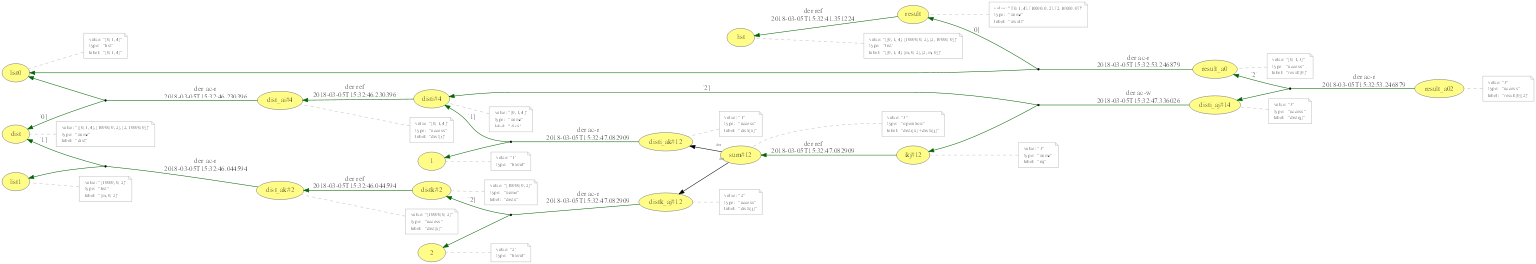

In [4]:
querier.load("../images/intertwined_prov/floydwarshall.provn");
view = "provn png svg pdf"
get_ipython().run_cell_magic(
    "provn",
    "-o {} -e {} -r RL".format("../images/intertwined_prov/query", view),
    '\n'.join(dfs("result_a02", neighborhood))
)